In [1]:
# This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '/home/roark/Documents/Assignments/cs231n\ spring2023/assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
sys.path.append(FOLDERNAME)

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
# %cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
# %cd /content/drive/My\ Drive/$FOLDERNAME
%cd $FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd $FOLDERNAME

/home/roark/Documents/Assignments/cs231n spring2023/assignment1/cs231n/datasets
/home/roark/Documents/Assignments/cs231n spring2023/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.421227
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$
$$Loss = -\frac{1}{N}∑_{i=1}^Nlog\frac{e^{S_{yi}}}{∑_je^S_j}$$
当w初始化为均值为0的极小值时，scores也大约为0附件的很小的值，因此$$e^{s_j}≈1$$
$$-\frac{1}{N}∑_{i=1}^Nlog\frac{e^{S_{yi}}}{∑_je^S_j}≈-\frac{1}{N}*N*log\frac{1}{C}≈-log\frac{1}{10}$$


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.394937 analytic: 1.394937, relative error: 6.166010e-08
numerical: 1.371441 analytic: 1.371441, relative error: 1.219285e-08
numerical: -1.676833 analytic: -1.676833, relative error: 4.208855e-09
numerical: 0.512277 analytic: 0.512277, relative error: 1.368770e-07
numerical: -0.005008 analytic: -0.005008, relative error: 1.665264e-06
numerical: -0.881773 analytic: -0.881773, relative error: 5.467675e-08
numerical: 0.933666 analytic: 0.933665, relative error: 9.209473e-08
numerical: 0.709353 analytic: 0.709353, relative error: 1.318490e-08
numerical: -1.388948 analytic: -1.388948, relative error: 8.664868e-09
numerical: 0.150382 analytic: 0.150382, relative error: 3.607515e-08
numerical: -0.896422 analytic: -0.896422, relative error: 3.628580e-08
numerical: -1.765670 analytic: -1.765670, relative error: 6.207775e-09
numerical: -0.354302 analytic: -0.354302, relative error: 7.265477e-08
numerical: -0.494962 analytic: -0.494963, relative error: 1.128896e-07
numerical: 0.54003

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.421227e+00 computed in 0.063115s
vectorized loss: 2.421227e+00 computed in 0.065270s
Loss difference: 0.000000
Gradient difference: 0.000000


In [7]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##################################
# rk's remark:                   #
#          random search         #
##################################

# sample learning_rates
exp_lr = -10 * np.random.rand(10)
learning_rates = np.power(10, exp_lr)

# sample regs
exp_reg = 7 * np.random.rand(10)
reg_strengths = np.power(10, exp_reg)
para_group = [(np.random.choice(learning_rates, replace=False), 
               np.random.choice(reg_strengths, replace=False)) for _ in range(20)]

###  comment out after try out coarse grid
# for lr, reg in para_group:
#     softmax = Softmax()
#     loss_history = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
#                                  num_iters=2000, verbose=True)
#     y_train_pred = softmax.predict(X_train)
#     train_acc = np.sum((y_train_pred == y_train)) / y_train.shape[0]
#     y_val_pred = softmax.predict(X_val)
#     val_acc = np.sum((y_val_pred == y_val)) / y_val.shape[0]
#     if(val_acc > best_val):
#         best_val=val_acc
#         best_softmax=softmax
#     results[(lr,reg)]=(train_acc,val_acc)
###  best result from coarse grid: 
###  => best validation accuracy achieved during cross-validation: 0.416000

### refine grid
lr_fine = [3e-7, 2e-6]
reg_fine = [1e1, 2e3]

for lr in np.linspace(lr_fine[0], lr_fine[1], 10):
    for reg in np.linspace(reg_fine[0], reg_fine[1], 10):
        softmax = Softmax()
        loss_history = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                                     num_iters=2000, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_acc = np.sum((y_train_pred == y_train)) / y_train.shape[0]
        y_val_pred = softmax.predict(X_val)
        val_acc = np.sum((y_val_pred == y_val)) / y_val.shape[0]
        if(val_acc > best_val):
            best_val=val_acc
            best_softmax=softmax
    results[(lr,reg)]=(train_acc,val_acc)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2000: loss 5.497876
iteration 100 / 2000: loss 3.531283
iteration 200 / 2000: loss 3.265861
iteration 300 / 2000: loss 3.246736
iteration 400 / 2000: loss 2.944879
iteration 500 / 2000: loss 2.855321
iteration 600 / 2000: loss 2.954015
iteration 700 / 2000: loss 2.920780
iteration 800 / 2000: loss 2.894346
iteration 900 / 2000: loss 2.789576
iteration 1000 / 2000: loss 2.892353
iteration 1100 / 2000: loss 2.465013
iteration 1200 / 2000: loss 2.369767
iteration 1300 / 2000: loss 2.712411
iteration 1400 / 2000: loss 2.414555
iteration 1500 / 2000: loss 2.576364
iteration 1600 / 2000: loss 2.524175
iteration 1700 / 2000: loss 2.325411
iteration 1800 / 2000: loss 2.466731
iteration 1900 / 2000: loss 2.546545
iteration 0 / 2000: loss 12.125510
iteration 100 / 2000: loss 9.973650
iteration 200 / 2000: loss 9.615809
iteration 300 / 2000: loss 9.277883
iteration 400 / 2000: loss 8.912798
iteration 500 / 2000: loss 8.676704
iteration 600 / 2000: loss 8.443298
iteration 700 / 2000:

iteration 300 / 2000: loss 8.713120
iteration 400 / 2000: loss 8.163628
iteration 500 / 2000: loss 7.962188
iteration 600 / 2000: loss 7.630918
iteration 700 / 2000: loss 7.317844
iteration 800 / 2000: loss 7.130055
iteration 900 / 2000: loss 6.639087
iteration 1000 / 2000: loss 6.467731
iteration 1100 / 2000: loss 6.211879
iteration 1200 / 2000: loss 5.878151
iteration 1300 / 2000: loss 5.632713
iteration 1400 / 2000: loss 5.624813
iteration 1500 / 2000: loss 5.428967
iteration 1600 / 2000: loss 5.199264
iteration 1700 / 2000: loss 4.996695
iteration 1800 / 2000: loss 4.921045
iteration 1900 / 2000: loss 4.706597
iteration 0 / 2000: loss 19.374917
iteration 100 / 2000: loss 15.591277
iteration 200 / 2000: loss 13.843738
iteration 300 / 2000: loss 12.733361
iteration 400 / 2000: loss 11.684613
iteration 500 / 2000: loss 10.813545
iteration 600 / 2000: loss 9.880511
iteration 700 / 2000: loss 9.148490
iteration 800 / 2000: loss 8.564586
iteration 900 / 2000: loss 7.937011
iteration 1000

iteration 700 / 2000: loss 7.577712
iteration 800 / 2000: loss 6.857596
iteration 900 / 2000: loss 6.284734
iteration 1000 / 2000: loss 5.704931
iteration 1100 / 2000: loss 5.271553
iteration 1200 / 2000: loss 4.773626
iteration 1300 / 2000: loss 4.522580
iteration 1400 / 2000: loss 4.179722
iteration 1500 / 2000: loss 3.969775
iteration 1600 / 2000: loss 3.633123
iteration 1700 / 2000: loss 3.566904
iteration 1800 / 2000: loss 3.276550
iteration 1900 / 2000: loss 3.125211
iteration 0 / 2000: loss 26.644890
iteration 100 / 2000: loss 19.711040
iteration 200 / 2000: loss 16.546613
iteration 300 / 2000: loss 13.908013
iteration 400 / 2000: loss 11.880873
iteration 500 / 2000: loss 10.106904
iteration 600 / 2000: loss 8.871859
iteration 700 / 2000: loss 7.725431
iteration 800 / 2000: loss 6.562599
iteration 900 / 2000: loss 5.742355
iteration 1000 / 2000: loss 5.014983
iteration 1100 / 2000: loss 4.508280
iteration 1200 / 2000: loss 4.009472
iteration 1300 / 2000: loss 3.688222
iteration 

iteration 1100 / 2000: loss 3.185232
iteration 1200 / 2000: loss 3.024622
iteration 1300 / 2000: loss 2.783022
iteration 1400 / 2000: loss 2.539938
iteration 1500 / 2000: loss 2.315261
iteration 1600 / 2000: loss 2.319602
iteration 1700 / 2000: loss 2.123912
iteration 1800 / 2000: loss 2.129748
iteration 1900 / 2000: loss 1.987255
iteration 0 / 2000: loss 33.888995
iteration 100 / 2000: loss 22.372229
iteration 200 / 2000: loss 16.778926
iteration 300 / 2000: loss 12.797692
iteration 400 / 2000: loss 9.516067
iteration 500 / 2000: loss 7.581520
iteration 600 / 2000: loss 6.000653
iteration 700 / 2000: loss 4.813806
iteration 800 / 2000: loss 4.022879
iteration 900 / 2000: loss 3.514332
iteration 1000 / 2000: loss 2.994215
iteration 1100 / 2000: loss 2.692504
iteration 1200 / 2000: loss 2.451137
iteration 1300 / 2000: loss 2.161931
iteration 1400 / 2000: loss 2.132244
iteration 1500 / 2000: loss 2.029609
iteration 1600 / 2000: loss 2.023033
iteration 1700 / 2000: loss 1.916260
iteration

iteration 1600 / 2000: loss 1.875674
iteration 1700 / 2000: loss 1.837173
iteration 1800 / 2000: loss 1.891866
iteration 1900 / 2000: loss 1.854745
iteration 0 / 2000: loss 39.814065
iteration 100 / 2000: loss 23.674674
iteration 200 / 2000: loss 15.313255
iteration 300 / 2000: loss 10.059193
iteration 400 / 2000: loss 6.937256
iteration 500 / 2000: loss 4.900637
iteration 600 / 2000: loss 3.817724
iteration 700 / 2000: loss 3.117335
iteration 800 / 2000: loss 2.538141
iteration 900 / 2000: loss 2.288354
iteration 1000 / 2000: loss 2.168023
iteration 1100 / 2000: loss 1.995646
iteration 1200 / 2000: loss 2.014976
iteration 1300 / 2000: loss 1.858652
iteration 1400 / 2000: loss 2.025104
iteration 1500 / 2000: loss 1.887050
iteration 1600 / 2000: loss 1.917187
iteration 1700 / 2000: loss 1.945444
iteration 1800 / 2000: loss 1.781073
iteration 1900 / 2000: loss 1.810064
iteration 0 / 2000: loss 46.959509
iteration 100 / 2000: loss 25.291790
iteration 200 / 2000: loss 15.007068
iteration 3

iteration 100 / 2000: loss 23.031535
iteration 200 / 2000: loss 12.640446
iteration 300 / 2000: loss 7.343618
iteration 400 / 2000: loss 4.543650
iteration 500 / 2000: loss 3.221867
iteration 600 / 2000: loss 2.664590
iteration 700 / 2000: loss 2.223941
iteration 800 / 2000: loss 2.094692
iteration 900 / 2000: loss 1.955958
iteration 1000 / 2000: loss 1.932178
iteration 1100 / 2000: loss 1.822736
iteration 1200 / 2000: loss 1.897326
iteration 1300 / 2000: loss 1.873750
iteration 1400 / 2000: loss 1.860584
iteration 1500 / 2000: loss 1.971841
iteration 1600 / 2000: loss 1.937446
iteration 1700 / 2000: loss 1.874440
iteration 1800 / 2000: loss 1.875196
iteration 1900 / 2000: loss 1.732834
iteration 0 / 2000: loss 53.627097
iteration 100 / 2000: loss 23.999002
iteration 200 / 2000: loss 11.977168
iteration 300 / 2000: loss 6.362317
iteration 400 / 2000: loss 3.817422
iteration 500 / 2000: loss 2.889333
iteration 600 / 2000: loss 2.341980
iteration 700 / 2000: loss 2.032846
iteration 800 /

iteration 600 / 2000: loss 1.956684
iteration 700 / 2000: loss 2.063960
iteration 800 / 2000: loss 2.007659
iteration 900 / 2000: loss 1.925635
iteration 1000 / 2000: loss 1.907014
iteration 1100 / 2000: loss 1.758966
iteration 1200 / 2000: loss 1.800008
iteration 1300 / 2000: loss 1.872717
iteration 1400 / 2000: loss 1.926109
iteration 1500 / 2000: loss 1.795156
iteration 1600 / 2000: loss 1.941684
iteration 1700 / 2000: loss 1.870749
iteration 1800 / 2000: loss 1.836587
iteration 1900 / 2000: loss 1.941843
iteration 0 / 2000: loss 60.836966
iteration 100 / 2000: loss 21.357555
iteration 200 / 2000: loss 8.805163
iteration 300 / 2000: loss 4.247733
iteration 400 / 2000: loss 2.771104
iteration 500 / 2000: loss 2.129521
iteration 600 / 2000: loss 2.042267
iteration 700 / 2000: loss 1.869616
iteration 800 / 2000: loss 1.969910
iteration 900 / 2000: loss 1.878583
iteration 1000 / 2000: loss 1.951942
iteration 1100 / 2000: loss 1.911699
iteration 1200 / 2000: loss 1.841650
iteration 1300 

iteration 1100 / 2000: loss 1.937178
iteration 1200 / 2000: loss 1.863890
iteration 1300 / 2000: loss 1.831781
iteration 1400 / 2000: loss 1.889662
iteration 1500 / 2000: loss 1.922603
iteration 1600 / 2000: loss 2.047688
iteration 1700 / 2000: loss 1.884077
iteration 1800 / 2000: loss 1.935602
iteration 1900 / 2000: loss 1.913168
iteration 0 / 2000: loss 67.125764
iteration 100 / 2000: loss 18.571206
iteration 200 / 2000: loss 6.273172
iteration 300 / 2000: loss 3.026541
iteration 400 / 2000: loss 2.208510
iteration 500 / 2000: loss 1.895907
iteration 600 / 2000: loss 1.973884
iteration 700 / 2000: loss 1.844341
iteration 800 / 2000: loss 1.820220
iteration 900 / 2000: loss 1.902422
iteration 1000 / 2000: loss 2.011127
iteration 1100 / 2000: loss 1.896117
iteration 1200 / 2000: loss 1.812412
iteration 1300 / 2000: loss 1.885839
iteration 1400 / 2000: loss 1.940677
iteration 1500 / 2000: loss 1.855069
iteration 1600 / 2000: loss 1.970674
iteration 1700 / 2000: loss 1.939971
iteration 1

iteration 1600 / 2000: loss 1.915913
iteration 1700 / 2000: loss 1.934217
iteration 1800 / 2000: loss 1.863821
iteration 1900 / 2000: loss 1.821264
iteration 0 / 2000: loss 5.685438
iteration 100 / 2000: loss 2.795097
iteration 200 / 2000: loss 2.666134
iteration 300 / 2000: loss 2.600846
iteration 400 / 2000: loss 2.294817
iteration 500 / 2000: loss 2.278886
iteration 600 / 2000: loss 2.239203
iteration 700 / 2000: loss 2.387878
iteration 800 / 2000: loss 2.160814
iteration 900 / 2000: loss 2.390038
iteration 1000 / 2000: loss 2.036119
iteration 1100 / 2000: loss 2.177142
iteration 1200 / 2000: loss 2.088688
iteration 1300 / 2000: loss 2.040979
iteration 1400 / 2000: loss 2.026663
iteration 1500 / 2000: loss 1.925593
iteration 1600 / 2000: loss 2.068253
iteration 1700 / 2000: loss 1.984947
iteration 1800 / 2000: loss 2.130893
iteration 1900 / 2000: loss 2.202270
iteration 0 / 2000: loss 12.716220
iteration 100 / 2000: loss 8.192326
iteration 200 / 2000: loss 6.879818
iteration 300 / 2

In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.380000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



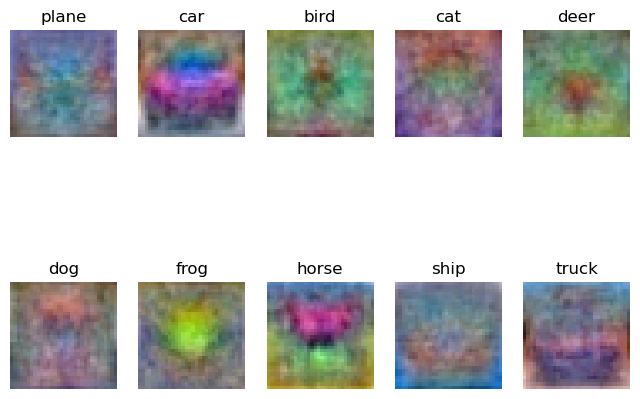

In [9]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])